In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import OneHotEncoder

# 可視化ツールのimport
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

from catboost import CatBoostRegressor

from sklearn.preprocessing import StandardScaler

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

temp=dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12), 
                           height=500, width=1000))
#色コード
class CLR:
    map_1 = 'GnBu'
    blue_thin = '#88CAC9'
    blue_dark = '#38A6A5'
    pink_thin = '#eb8792'
    pink_dark = '#ec616e'
    orange = '#f8b287'
    orange_dark = '#ee572a'

In [3]:
df_train = pd.read_csv('./kaggle/input/titanic/train.csv')
df_test = pd.read_csv('./kaggle/input/titanic/test.csv')
df_example = pd.read_csv('./kaggle/input/titanic/gender_submission.csv')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
def preprocess(df:pd.core.frame.DataFrame, istrain:bool) -> pd.core.frame.DataFrame:
    droped_columns = ['PassengerId','Name','Ticket',"Cabin"]
    df = df.drop(columns=droped_columns)
    df = df.fillna(df.mode().iloc[0])
    df = pd.get_dummies(df)
    if istrain == True:
        target_column = df['Survived']
        df.drop(columns='Survived', inplace=True)

    scaler=StandardScaler()
    df_scaled =pd.DataFrame(scaler.fit_transform(df),columns=df.columns)
    # Survived列を元のDataFrameに結合
    if istrain == True:
        df_scaled['Survived'] = target_column
    return df

df_preprocessed = preprocess(df_train, True)
df_preprocessed_test = preprocess(df_test, False)
df_preprocessed.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,False,True,False,False,True
1,1,38.0,1,0,71.2833,True,False,True,False,False
2,3,26.0,0,0,7.9250,True,False,False,False,True
3,1,35.0,1,0,53.1000,True,False,False,False,True
4,3,35.0,0,0,8.0500,False,True,False,False,True


In [5]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
# 欠損値がないか確認
df_preprocessed.isnull().sum(axis=0)#データの欠測値を一覧表示

Pclass        0
Age           0
SibSp         0
Parch         0
Fare          0
Sex_female    0
Sex_male      0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64

In [7]:
from sklearn.model_selection import train_test_split
df_train_x = df_preprocessed
df_train_y = df_train['Survived']
x_train, x_val, y_train, y_val = train_test_split(df_train_x, df_train_y, test_size=0.15, random_state=42)

X_test = df_preprocessed_test

In [8]:
cb_model = CatBoostRegressor(iterations=500,
                             learning_rate=0.05,
                             depth=10,
                             eval_metric='RMSE',
                             random_seed = 42,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 50,
                             od_wait=20)

In [10]:
cb_model.fit(x_train, y_train,
             eval_set=(x_val, y_val),
             use_best_model=True,
             verbose=50)

0:	learn: 0.4751013	test: 0.4844560	best: 0.4844560 (0)	total: 152ms	remaining: 1m 15s
50:	learn: 0.3271144	test: 0.3590063	best: 0.3590063 (50)	total: 627ms	remaining: 5.52s
100:	learn: 0.3004029	test: 0.3500948	best: 0.3498416 (99)	total: 1.11s	remaining: 4.4s
150:	learn: 0.2829237	test: 0.3459643	best: 0.3456421 (143)	total: 1.6s	remaining: 3.69s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3456420507
bestIteration = 143

Shrink model to first 144 iterations.


In [15]:
y_pred_cat = np.expm1(cb_model.predict(X_test))

In [12]:
df_answer = pd.read_csv('./kaggle/input/titanic/answer.csv')
Y_test = df_answer['Survived']

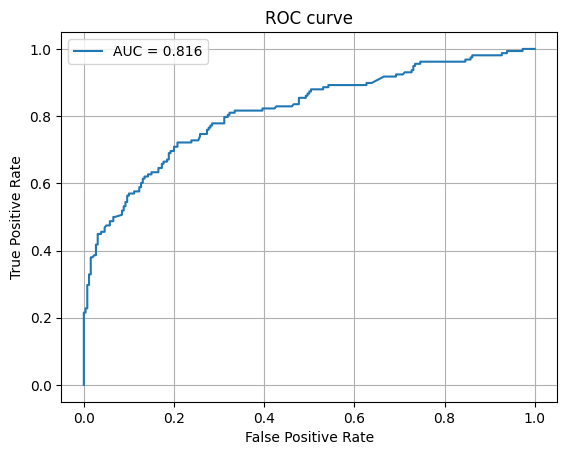

In [16]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_cat)
auc_score = roc_auc_score(Y_test, y_pred_cat)
plt.plot(fpr, tpr, label='AUC = %.3f' % (auc_score))
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)


# accuracy: 0.8208955223880597
# f1_score: 0.7446808510638298
